In [1]:
# 1) Setup imports and path
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os

# make repo importable
sys.path.append(str(Path('..').resolve()))
from src import evaluation

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
# 2) Configure: ground-truth CSV path and results root (adjust as needed)
GT_CSV = '../results/gt_mug/gt.csv'  # <-- EDIT THIS to point to your ground-truth CSV
RESULTS_ROOT = '../results'  # where your trackers write per-experiment folders
CLE_THRESHOLD = 20.0

# Collect candidate result folders that contain predictions.csv
root = Path(RESULTS_ROOT)
candidates = []
if root.exists():
    for p in sorted(root.iterdir()):
        preds = p / 'predictions.csv'
        if preds.exists():
            candidates.append(str(p))

# If no candidates found, you can still manually list directories
candidates[:10]

['../results/q1_basic', '../results/q6_deep_meanshift']

In [3]:
# 3) Run evaluation across candidates and build a DataFrame
# Use the specific absolute path provided by the user (override auto-discovery)
candidates = ["/Users/wuwanxing/Documents/projects/python/object_tracking/results/evaluation/hs_mug"]

results = []
for pred_dir in candidates:
    pred_csv = os.path.join(pred_dir, 'predictions.csv')
    try:
        res = evaluation.evaluate(pred_csv, GT_CSV, cle_threshold=CLE_THRESHOLD)
    except Exception as e:
        print(f'Failed to evaluate {pred_dir}: {e}')
        continue
    res_row = {
        'experiment': os.path.basename(pred_dir),
        'n_frames': res.get('n_frames'),
        'success_rate': res.get('success_rate'),
        'precision': res.get('precision'),
        'mean_iou': res.get('mean_iou'),
        'mean_cle': res.get('mean_cle'),
        'fps': res.get('fps')
    }
    results.append(res_row)

# Handle the case where no results were produced to avoid KeyError when sorting/ indexing
if not results:
    print("No evaluation results were produced. Check that `candidates` is not empty and that predictions.csv files exist.")
    df = pd.DataFrame(columns=['experiment','n_frames','success_rate','precision','mean_iou','mean_cle','fps'])
else:
    df = pd.DataFrame(results)
    df = df.sort_values('experiment').reset_index(drop=True)
df

,experiment,n_frames,success_rate,precision,mean_iou,mean_cle,fps
0,hs_mug,11,0.0,0.0,0.060566,99.112596,13.511501


Saved summary to: ../results/evaluation/evaluation_summary.csv


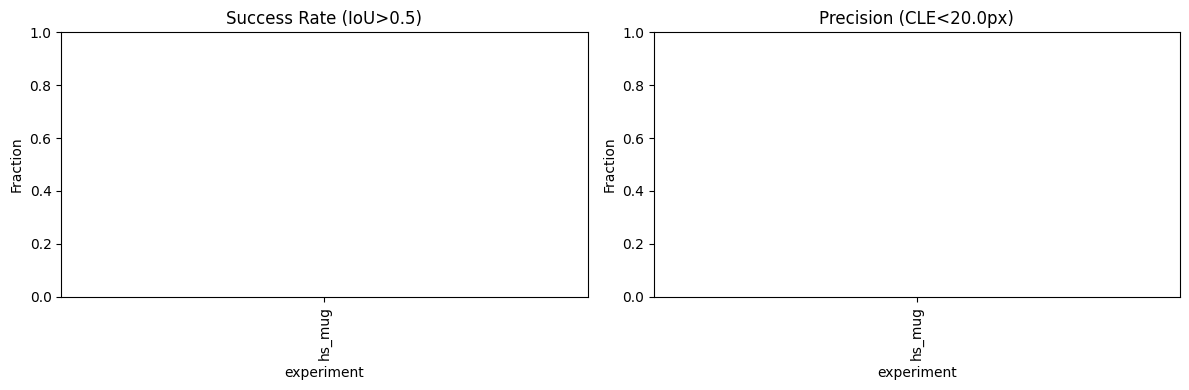

In [4]:
# 4) Save a summary CSV and plot metrics (Success Rate and Precision)
out_dir = Path(RESULTS_ROOT) / 'evaluation'
out_dir.mkdir(parents=True, exist_ok=True)
summary_csv = out_dir / 'evaluation_summary.csv'
df.to_csv(summary_csv, index=False)
print(f'Saved summary to: {summary_csv}')

# Plotting
if not df.empty:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    df.plot(kind='bar', x='experiment', y='success_rate', ax=ax[0], legend=False)
    ax[0].set_title('Success Rate (IoU>0.5)')
    ax[0].set_ylabel('Fraction')
    ax[0].set_ylim(0,1)

    df.plot(kind='bar', x='experiment', y='precision', ax=ax[1], legend=False, color='orange')
    ax[1].set_title(f'Precision (CLE<{CLE_THRESHOLD}px)')
    ax[1].set_ylabel('Fraction')
    ax[1].set_ylim(0,1)

    plt.tight_layout()
    plt.show()
else:
    print('No evaluation results to plot.')